Jeff Dunagin

DSC 530

Exercise 10.2

# 12.1
The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [16]:
# imports and code from the book

import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

In [7]:
# load the data
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
dailies = GroupByQualityAndDay(transactions)

name = 'high'
daily = dailies[name]

In [11]:
# now write a quadratic model
def RunQuadraticModel(daily):
    """Runs a linear model of prices versus years.

    daily: DataFrame of daily prices

    returns: model, results
    """
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

In [12]:
# use the quadratic model
model, results = RunQuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          4.57e-164
Time:                        01:47:23   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

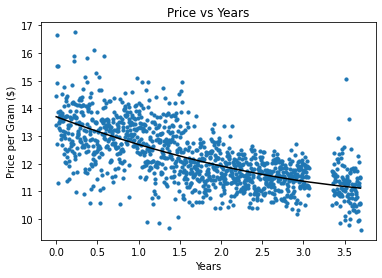

In [23]:
years = model.exog[:,1]
values = model.endog

plt.scatter(years,values, s=10)
plt.plot(years, results.fittedvalues,color = 'k', label='fit')
plt.ylabel('Price per Gram ($)')
plt.xlabel('Years')
plt.title('Price vs Years')
plt.show()

# 12.2
Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [26]:
import thinkstats2

In [29]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    """Tests serial correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag
    
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [33]:
# test the correlation between consecutive prices

name = 'high'
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.4852293761947382 0.0


There is a 0.49 correlation between consecutive prices. The p-value is (very close to) zero, so this is significant.

In [31]:
# test for serial correlation in residuals of the linear model

_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)    

0.07570473767506267 0.007


The residuals have a very small correlation, which is significant given the p-value.

In [32]:
# test for serial correlation in residuals of the quadratic model

_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue) 

0.05607308161289925 0.043


This also has a very low positive correlation, with a significant p-value.